In [1]:
from sympy import *
init_printing()

In [2]:
from plot_setup import *
import model_definition as model
import seaborn as sns
#sns.set(style="ticks",palette="tab10")
sns.set_style('whitegrid')
sns.set_palette("tab10",10)
import matplotlib

#args_pairplot = {"size":5,"plot_kws":{"s":8,"marker":"o"},"diag_kws":{"bins":32,"histtype":"stepfilled","alpha":0.3}}
args_pairplot = {"plot_kws":{"s":8,"marker":"o"},"diag_kws":{"bins":32,"histtype":"stepfilled","alpha":0.3}}

def mypairplot(
    mcchain,
    scatter_kws={"s":1,"marker":"o","alpha":0.1},
    kde_kws={"shade":True,"shade_lowest":False,"cmap":"jet"},
    hist_kws={"bins":32,"histtype":"stepfilled","alpha":0.3},
    **kws):
    
    print("Note: The following warnings occur, but no problem.\nUserWarning: The following kwargs were not used by contour: 'label', 'color' ")
    g = sns.PairGrid(mcchain,**kws)
    g = g.map_upper(plt.scatter,**scatter_kws)
    g = g.map_lower(sns.kdeplot,**kde_kws)
    g = g.map_diag(plt.hist, **hist_kws)
    return g

In [3]:
r,R,r_e,R_RoI = symbols(r"r R r_e R_\text{RoI}",positive=True)
v = symbols("v")

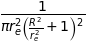

In [4]:
# definition of plummer model
plummer_2d = (1/pi/r_e**2)*(1+(R/r_e)**2)**(-2)
plummer_3d = (Rational(3,4)/pi/r_e**3)*(1+(r/r_e)**2)**(-Rational(5,2))
display(plummer_2d)

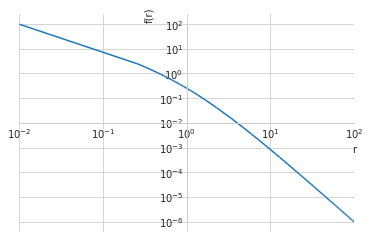

In [23]:
r_s, rho_s = symbols(r"r_s \rho_s",positive=True)
a,b,g = symbols(r"\alpha \beta \gamma")
general_NFW = rho_s*(r/r_s)**-g * (1+(r/r_s)**a)**(-(b-g)/a)
plot(general_NFW.subs([(a,1),(b,3),(g,1),(rho_s,1),(r_s,1)]),(r,1e-2,1e2),xscale="log",yscale="log")

In [84]:
G = symbols("G")
M = general_NFW
anib = symbols(r"\beta_\text{ani}")
r1 = symbols("r'",positive=True)
integrand_sigma_r = sympify(1/plummer_3d * plummer_3d.subs(r,r1)*(r1/r)**(2*anib)*(G*M.subs(r,r1)/r1**2))
display(integrand_sigma_r)
sigma_r =Integral(integrand_sigma_r,(r1,r,oo))
display(series(integrand_sigma_r,x=r1,x0=0,n=0))
plot(integrand_sigma_r.subs([(a,1),(b,3),(g,1),(r_e,1),(r_s,10),(rho_s,1),(anib,0),(G,1),(r,2)]),(r1,1e-2,1e2),xscale="log",yscale="log")

                                                                        -\beta
                                                                        ──────
                                                    5/2                      \
            2⋅\beta_\text{ani}     -\gamma ⎛  2    ⎞    ⎛    \alpha    ⎞      
        ⎛r'⎞                   ⎛r'⎞        ⎜ r     ⎟    ⎜⎛r'⎞          ⎟      
G⋅\rhoₛ⋅⎜──⎟                  ⋅⎜──⎟       ⋅⎜─── + 1⎟   ⋅⎜⎜──⎟       + 1⎟      
        ⎝r ⎠                   ⎝rₛ⎠        ⎜  2    ⎟    ⎝⎝rₛ⎠          ⎠      
                                           ⎝rₑ     ⎠                          
──────────────────────────────────────────────────────────────────────────────
                                                 5/2                          
                                        ⎛  2    ⎞                             
                                      2 ⎜r'     ⎟                             
                                    r' ⋅⎜─── + 1⎟   

KeyboardInterrupt: 

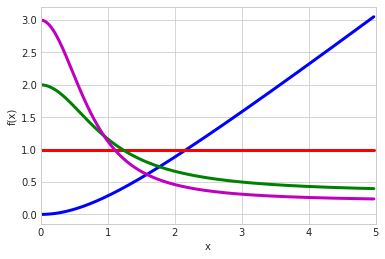

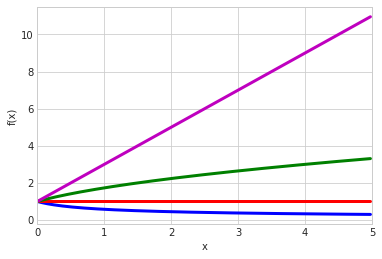

In [136]:
from sympy.abc import a,b,c,x
from mpmath import *
mp.dps = 25; mp.prettey = True
f = lambda beta : lambda x: ((3/2-beta)*(1+x**2)**(beta)*mpmath.hyp2f1(0.5,beta,1.5,-x**2)-1/2)
plot([f(b)for b in (1.,0.,-1.,-2.)], [0,5])
f1 = lambda beta : lambda x : (1+x*2)**(-beta)
plot([f1(b) for b in (1.,0.,-1.,-2.)], [0,5])

# Inverse transform sampling of Plummer distribution
If you have pdf $p(x)$, translate it to cdf $U(x) = \int_0^x dx' p(x')$. Then,

$x = U^{-1}(u)$ is the samples whose distribution is p(x) where $u \sim U(0,1)$ (uniform distribution) 

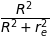

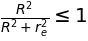

In [9]:
# U(x) for Plummer 
R1 = symbols(r"R'",positive=True)
Sigma = plummer_2d.subs(R,R1)
cdf = simplify(integrate(2*pi*R1*Sigma,(R1,0,R)))
# cdf : cummulated probability
display(cdf)
refine(cdf<=1,Q.positive(1-cdf))

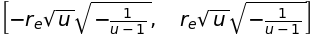

In [10]:
# U^{-1}(u) for Plummer 

u = symbols("u",positive = True)
assumptions.refine(u,Q.positive(1-u))
# solve(expr,var) : solve expr = 0 for var
inv_cdfs = solve(cdf-u, R)
display(u<=1)
display(inv_cdfs)

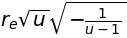

In [11]:
inv_cdf = inv_cdfs[1]
inv_cdf

In [12]:
# Member parameter and functions
r_e_obs = 100
v_mem = 50
sigma_los = lambda R: 10+10*(R/r_e_obs)
_generate_plummer_R_from_u = lambdify(u,inv_cdf.subs(r_e,r_e_obs),"numpy")
generate_plummer_R = lambda n: _generate_plummer_R_from_u(np.random.rand(n))

Note: The following warnings occur, but no problem.


/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


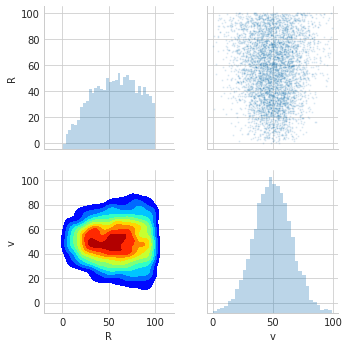

In [18]:
# create mock here
n_sample = 1000000
plummer_vRs = pd.DataFrame()
plummer_vRs["R"] = generate_plummer_R(n_sample)
plummer_vRs["v"] = np.random.normal(loc=v_mem,scale=sigma_los(plummer_vRs["R"]))
isin_RoI = lambda df: (df.R<200).values * (df.v<100).values * (0<df.v).values
#isin_RoI(plummer_vRs)
plummer_vRs_in_RoI = plummer_vRs[isin_RoI(plummer_vRs)]
#display(plummer_vRs_in_RoI)
mypairplot(plummer_vRs_in_RoI[::100])

In [228]:
# Foreground parameter and functions
v_fg = 200
dv_fg = 200
RoI_R_obs = 200
#_generate_uniform_R_from_u = lambdify(u,inv_cdf.subs(r_e,r_e_obs),"numpy")
generate_uniform_R = lambda n: np.random.triangular(size=n_sample,left=0,mode=RoI_R_obs,right=RoI_R_obs)

In [238]:
# create mock here
n_sample = 1000000
uniform_vRs = pd.DataFrame()
uniform_vRs["R"] = generate_uniform_R(n_sample)
uniform_vRs["v"] = np.random.normal(size=n_sample,loc=v_fg,scale=dv_fg)
isin_RoI = lambda df: (df.R<100).values * (df.v<100).values * (0<df.v).values
#isin_RoI(plummer_vRs)
uniform_vRs_in_RoI = uniform_vRs[isin_RoI(uniform_vRs)]
display(uniform_vRs_in_RoI)
#mypairplot(uniform_vRs_in_RoI)
#uniform_vRs.to_csv("mock_fg_"+specify_name+".csv")

,R,v
3,65.017657,65.060400
24,87.025471,42.592599
76,74.813912,70.321889
90,52.617250,2.683799
137,97.477318,96.216461
187,97.361491,82.391917
195,58.923347,87.991784
239,39.154605,79.708519
307,76.251312,10.072256
311,82.864194,46.199477


In [239]:
# output the files
specify_name = "noMCMC1milion_v001"
plummer_vRs.to_csv("mock_mem_"+specify_name+".csv")
uniform_vRs.to_csv("mock_fg_"+specify_name+".csv")